# Methods Overview
This Jupyter notebook analyses manta ray acoustic telemetry data from Lady Elliot Island (LEI) to assess the relationship between manta residence times and chlorophyll-a concentration.

### Workflow 
1. **Data Loading:** Import raw manta detection data and chlorophyll-a datasets.
2. **Data Preprocessing:** Filter detection timestamps.
3. **Residence Time Calculation:** Identify residence periods based on detection frequency.
4. **Chlorophyll Extraction:** Subset eReefs dataset for Lady Elliot Island region.
5. **Integration:** Merge residence and chlorophyll data by month.
6. **Analysis & Visualisation:** Plot time-series trends and compute correlations.


Step 1. Import required Dependencies 

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import warnings

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from siphon.catalog import TDSCatalog
from netCDF4 import num2date

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Directory setup
input_dir = "MantaTimeseries_Inputs"
output_dir = "MantaTimeseries_Outputs/plots"
os.makedirs(output_dir, exist_ok=True)

cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

Step 2. Load Manta Data

In [3]:
# Load manta data
manta_path = os.path.join(input_dir, "raw_manta_data.xlsx")
manta = pd.read_excel(manta_path)

manta["detection_datetime"] = pd.to_datetime(manta["detection_datetime"])
manta["hour"] = manta["detection_datetime"].dt.floor('h')

print(f"Loaded {len(manta)} detections from {manta_path}")

Loaded 514595 detections from MantaTimeseries_Inputs/raw_manta_data.xlsx


In [4]:
manta.head()

,detection_datetime,transmitter_id,tag_id,transmitter_deployment_id,tag_device_project_name,tag_deployment_project_name,species_common_name,species_scientific_name,CAAB_species_id,WORMS_species_aphia_id,...,receiver_name,receiver_deployment_id,receiver_deployment_longitude,receiver_deployment_latitude,transmitter_sensor_type,transmitter_status,transmitter_deployment_longitude,transmitter_deployment_latitude,transmitter_deployment_datetime,hour
0,2009-06-09,A69-1303-14679,60492651,130578642,Project Manta,Project Manta,Manta Ray,Mobula alfredi,37041005,1042871,...,VR2W-101739,70528446,152.71,-24.11,PRESSURE,CURRENT,152.71,-24.11,2009-06-09,2009-06-09
1,2009-06-09,A69-1303-14679,60492651,130578642,Project Manta,Project Manta,Manta Ray,Mobula alfredi,37041005,1042871,...,VR2W-101739,70528446,152.71,-24.11,PRESSURE,CURRENT,152.71,-24.11,2009-06-09,2009-06-09
2,2009-06-09,A69-1303-14679,60492651,130578642,Project Manta,Project Manta,Manta Ray,Mobula alfredi,37041005,1042871,...,VR2W-101739,70528446,152.71,-24.11,PRESSURE,CURRENT,152.71,-24.11,2009-06-09,2009-06-09
3,2009-06-09,A69-1303-14679,60492651,130578642,Project Manta,Project Manta,Manta Ray,Mobula alfredi,37041005,1042871,...,VR2W-101739,70528446,152.71,-24.11,PRESSURE,CURRENT,152.71,-24.11,2009-06-09,2009-06-09
4,2009-06-09,A69-1303-14679,60492651,130578642,Project Manta,Project Manta,Manta Ray,Mobula alfredi,37041005,1042871,...,VR2W-101739,70528446,152.71,-24.11,PRESSURE,CURRENT,152.71,-24.11,2009-06-09,2009-06-09


Step 3. Calculate Hourly Detections

In [5]:
hour_counts = (
    manta.groupby(['transmitter_id', 'receiver_name', 'hour'])
    .size()
    .reset_index(name='ping_count')
)

In [6]:
# Keep only hours with ≥2 detections (real presence)
valid_hours = hour_counts[hour_counts['ping_count'] >= 2].copy()

Step 4. Identify Residence Periods 

In [7]:
valid_hours = valid_hours.sort_values(['transmitter_id', 'receiver_name', 'hour'])

# Calculate gap in hours between consecutive valid hours
valid_hours['hour_gap'] = (
    valid_hours.groupby(['transmitter_id', 'receiver_name'])['hour']
    .diff()
    .dt.total_seconds() / 3600
)

# Start new residence group whenever gap >120 h (5 days)
valid_hours['res_group'] = (
    valid_hours.groupby(['transmitter_id', 'receiver_name'])['hour_gap']
    .transform(lambda x: (x > 120).cumsum())
)

Step 5. Compute Residence Durations

In [8]:
# --- Calculate duration (in hours) of each residence period ---
residence_periods = (
    valid_hours.groupby(['transmitter_id', 'receiver_name', 'res_group'])
    .agg(
        start_hour=('hour', 'min'),
        end_hour=('hour', 'max'),
        duration_hours=('hour', lambda x: (x.max() - x.min()).total_seconds() / 3600 + 1)
    )
    .reset_index()
)

In [9]:
# --- Assign each residence to its start month ---
residence_periods['month'] = pd.to_datetime(residence_periods['start_hour']).dt.to_period('M')

Step 6. Compute Monthly Average Residence Time 

In [10]:
# --- Compute monthly average residence time ---
rt_monthly = (
    residence_periods.groupby('month')['duration_hours']
    .mean()
    .reset_index()
    .rename(columns={'duration_hours': 'avg_residence_time_hours'})
)

In [11]:
# --- Filter study period ---
rt_filtered = (
    rt_monthly[
        (rt_monthly["month"] >= "2011-01") & (rt_monthly["month"] <= "2013-12")
    ]
    .copy()  
)
rt_filtered["month"] = rt_filtered["month"].dt.to_timestamp()

Step 7. Plot the calculated residence time 

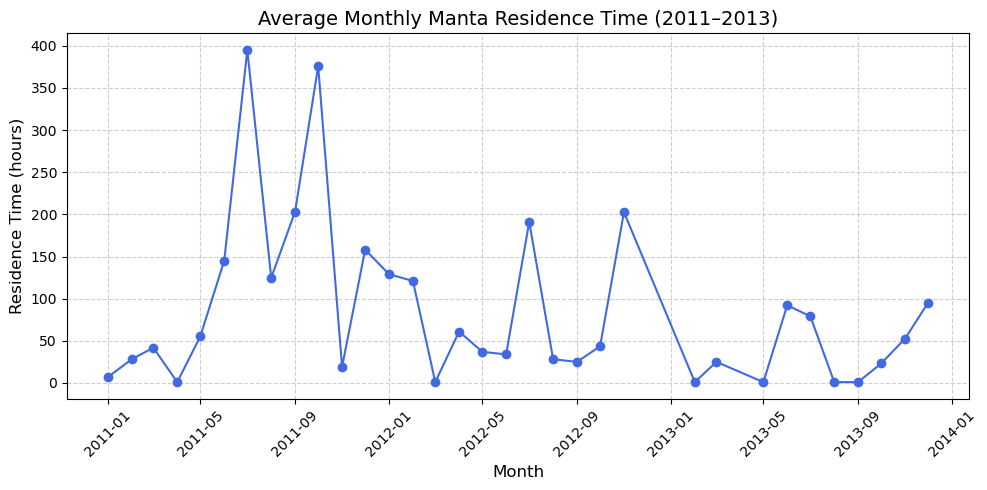

In [12]:
# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(rt_filtered["month"], rt_filtered["avg_residence_time_hours"], marker="o", color="royalblue")
plt.title("Average Monthly Manta Residence Time (2011–2013)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Residence Time (hours)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "residence_timeseries.png"), dpi=300)
plt.show()

Step 8. Load Chlorophyll data from eReefs

In [13]:
# Initialise variables specific to this dataset
catUrl = "https://thredds.ereefs.aims.gov.au/thredds/catalog/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd.xml"
datasetName = "BioGeoChemical model - Baseline scenario (GBR4_H2p0_B3p1_Cq3b_Dhnd) - monthly"

In [14]:
catalog = TDSCatalog(catUrl)

In [15]:
ds = catalog.datasets[datasetName]
ds.name

'BioGeoChemical model - Baseline scenario (GBR4_H2p0_B3p1_Cq3b_Dhnd) - monthly'

In [16]:
list(ds.access_urls)

['OPeNDAP', 'WCS', 'WMS', 'NetcdfSubset', 'CdmRemote']

In [17]:
dataset = ds.remote_access()

In [18]:
# === Automatically select the Chlorophyll-a variable ===
chl_var = dataset.variables['Chl_a_sum']

In [19]:
# === Extract dimension variables ===
for dim_var in dataset.variables.values():
    if 'coordinate_type' in dim_var.ncattrs():
        if dim_var.coordinate_type == 'time':
            time_var = dim_var

In [20]:
# === use time dimension directly from the chlorophyll variable ===
time_dim = dataset.variables[chl_var.dimensions[0]]  
time = num2date(time_dim[:], time_dim.units)
time_py = pd.to_datetime([t.strftime('%Y-%m-%d') for t in time])

print("Number of time steps:", len(time_py))

Number of time steps: 101


Step 9. Define Spatial Subset around Lady Elliot Island

In [21]:
# === Load coordinate arrays ===
lat = dataset.variables['latitude'][:]
lon = dataset.variables['longitude'][:]
print("Latitude range:", lat.min(), "to", lat.max())
print("Longitude range:", lon.min(), "to", lon.max())

# === Define coordinates  ===
# Lady Elliot Island area
lat_min, lat_max = -24.14, -24.09
lon_min, lon_max = 152.70, 152.73


# === Find indices inside bounding box ===
lat_idx = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_idx = np.where((lon >= lon_min) & (lon <= lon_max))[0]

print(f"Selected lat indices: {lat_idx[0]}–{lat_idx[-1]}")
print(f"Selected lon indices: {lon_idx[0]}–{lon_idx[-1]}")
print(f"Latitude range subset: {lat[lat_idx[0]]:.3f}–{lat[lat_idx[-1]]:.3f}")
print(f"Longitude range subset: {lon[lon_idx[0]]:.3f}–{lon[lon_idx[-1]]:.3f}")

Latitude range: -28.696022 to -7.036022
Longitude range: 142.168788 to 156.868788
Selected lat indices: 152–153
Selected lon indices: 352–352
Latitude range subset: -24.136–-24.106
Longitude range subset: 152.729–152.729


In [22]:
# --- Get vertical coordinate ---
zc = dataset.variables['zc'][:]   # depth midpoints in metres (positive downward)
print("Depth levels (m):", zc[:10])

# --- Find layer closest to 0.5 m ---
target_depth = 0.5
depth_idx = np.abs(zc - target_depth).argmin()
print(f"Using zc index {depth_idx} at depth {zc[depth_idx]:.2f} m (surface layer)")


Depth levels (m): [-145.   -120.   -103.    -88.    -73.    -60.    -49.    -39.5   -31.
  -23.75]
Using zc index 16 at depth -0.50 m (surface layer)


In [23]:
# # === Extract and download surface chlorophyll ===
chl_subset = chl_var[:, depth_idx, lat_idx[0]:lat_idx[-1]+1, lon_idx[0]:lon_idx[-1]+1].data
print("chl_subset shape:", chl_subset.shape)
print("chl_subset min:", np.nanmin(chl_subset))
print("chl_subset max:", np.nanmax(chl_subset))

chl_subset shape: (101, 2, 1)
chl_subset min: 0.3430676
chl_subset max: 1.6250458


In [24]:
# === Compute spatial mean for each month ===
chl_mean_monthly = np.nanmean(chl_subset, axis=(1, 2))
print("Mean monthly chlorophyll shape:", chl_mean_monthly.shape)

Mean monthly chlorophyll shape: (101,)


In [25]:
# === Combine into a DataFrame ===
chl_df = pd.DataFrame({
    'time': time_py[:len(chl_mean_monthly)],
    'chlorophyll_a_mg_m3': chl_mean_monthly
}).set_index('time')

# === Subset to years 2011–2013 ===
chl_df_subset = chl_df.loc['2011':'2013']

Step 10. Plot Chlorophyll Time Series

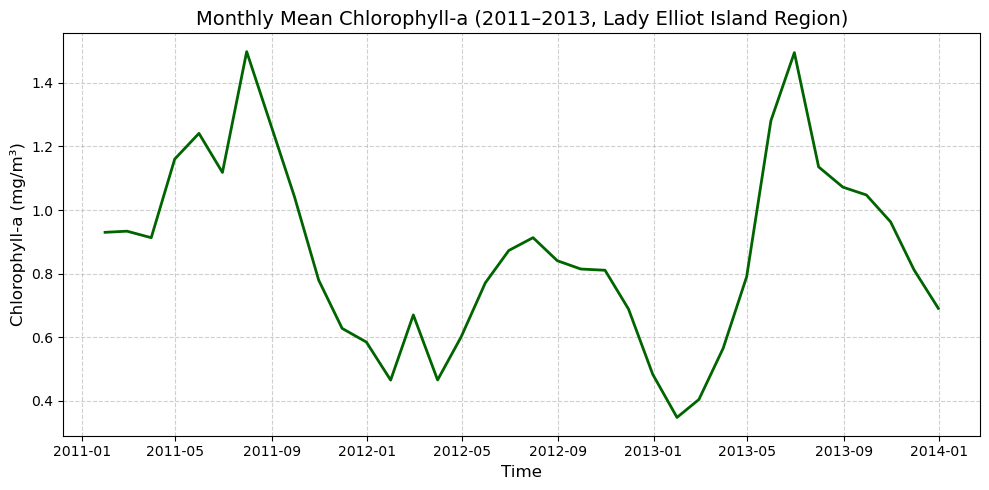

In [26]:
# === Plot subset (2011–2013) ===
plt.figure(figsize=(10, 5))
plt.plot(chl_df_subset.index, chl_df_subset["chlorophyll_a_mg_m3"], color="darkgreen", lw=2)
plt.title("Monthly Mean Chlorophyll-a (2011–2013, Lady Elliot Island Region)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Chlorophyll-a (mg/m³)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "chlorophyll_timeseries.png"), dpi=300)
plt.show()

In [27]:
# Convert both to monthly PeriodIndex, then back to timestamps (month start)
chl_df_subset.index = chl_df_subset.index.to_period("M").to_timestamp()

Step 11. Merge Manta Residence and Chlorophyll data 

In [28]:
# Merge again
combined_df = pd.merge(rt_filtered.set_index("month"), chl_df_subset, left_index=True, right_index=True, how="inner")

print(combined_df.head())

            avg_residence_time_hours  chlorophyll_a_mg_m3
2011-01-01                  7.000000             0.929797
2011-02-01                 28.200000             0.933406
2011-03-01                 41.800000             0.912898
2011-04-01                  1.000000             1.160089
2011-05-01                 55.315789             1.241044


Step 12. Plot Combined Time Series 

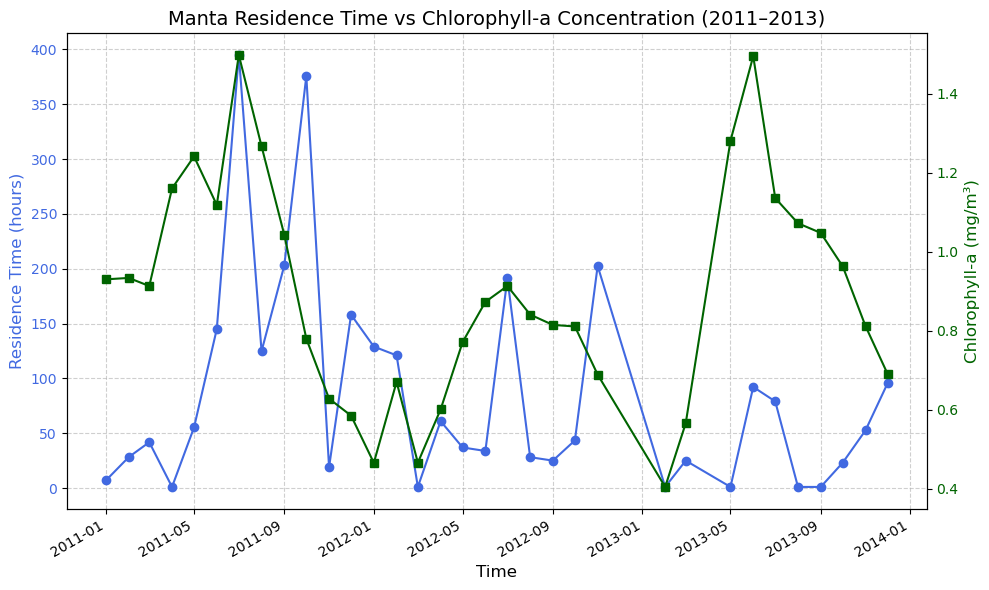

In [29]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(combined_df.index, combined_df["avg_residence_time_hours"], color="royalblue", marker="o", label="Residence Time")
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("Residence Time (hours)", color="royalblue", fontsize=12)
ax1.tick_params(axis="y", labelcolor="royalblue")
ax1.grid(True, linestyle="--", alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(combined_df.index, combined_df["chlorophyll_a_mg_m3"], color="darkgreen", marker="s", label="Chlorophyll-a")
ax2.set_ylabel("Chlorophyll-a (mg/m³)", color="darkgreen", fontsize=12)
ax2.tick_params(axis="y", labelcolor="darkgreen")

plt.title("Manta Residence Time vs Chlorophyll-a Concentration (2011–2013)", fontsize=14)
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_timeseries.png"), dpi=300)
plt.show()

Step 13. Check Correlation 

In [30]:
corr = combined_df['avg_residence_time_hours'].corr(combined_df['chlorophyll_a_mg_m3'])
print(f"Pearson correlation: {corr:.3f}")


Pearson correlation: 0.188
